感觉NN很多东西都是经验性的，尤其对于deep neural network，像黑箱，难以看清到底是怎么运转的，但是依旧可以通过visualizing weights,gradients or activations来tune model。这个notebook重点在于weight initialization(kaiming_normal，sparse initialization),batch normalization(make model less sensitive to learning rates and initialization, has regularization effect),以尽量使得activations满足高斯分布，avoid dead neurons and covariate shift(it is advantgeous for the distribution of x to remain fixed over time, then weight doesnt have to rejust to compensate for the change in the distributionof x)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words=open('C:\\Users\\Administrator\\Desktop\\NN\\Python\\name.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [26]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)  #random numbers from N(0,1)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
#problem2: gradient through tanh only decrease, 等于0的值的gradient直接穿过去，绝对值越大gradient越越接近0，等于0的gradient对减小loss没用
#（看tanh函数的图，左右两边几乎是平的）
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
#Problem1:what values should be taken at initialization? we want initialized logits to be equally zero(or just equal)(which results in 
#uniform output distribution,if we totally randomize it, it is highly likely that faultly confident probility to each class,即logits数值
#差别很大的情况)为了得到一个好的初始值（即logits roughly equal to 0），在W2，b2后面乘以0，不让logits exatly等于0保留了一些variation,
#在实践中表现更好。 调整之后的更reasonable的初始值可以获得更好的效果，因为节省了前面easy的GD部分，有更多时间converge到一个较好的值

parameters = [C, W1, W2, b2, b1]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [30]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors  #32*3*10
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors  #32*30
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation  #32*200
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function  #这个函数包含了softmax

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


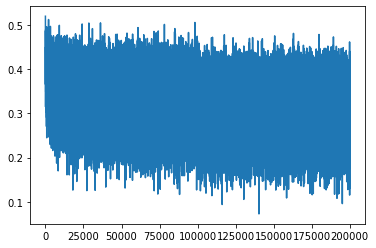

In [13]:
plt.plot(lossi)

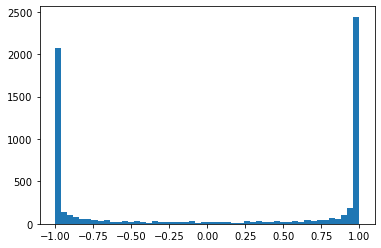

In [18]:
plt.hist(h.view(-1).tolist(),50); #有很多等于1或-1的值

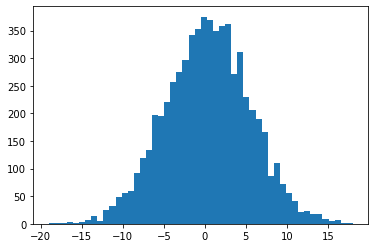

In [25]:
plt.hist(hpreact.view(-1).tolist(),50);  #too many extreme values,we hope hpreact closely to zero,the way to achieve this is 在W1，b1后面
#乘以一个很小的数

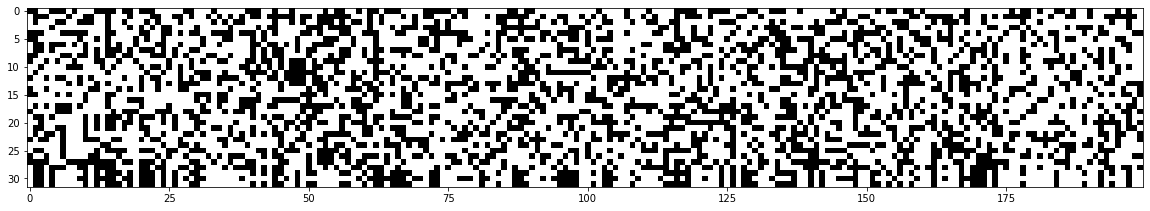

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')  #white:true,black:false 白色的说明位于tanh函数的flag tile
#a totally white collum(block里面32个h值都等于0) means dead neurons,means this neurons never learn, which we dont want to happpen
#(less learning, less fluently updated)
#这个问题同样出现在sigmoid,Relu,Elu。

W1和b1乘以后面的很小的数之后

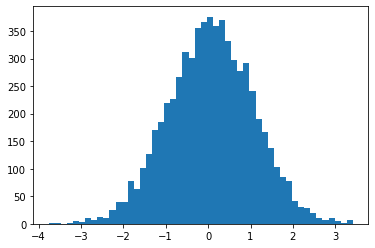

In [28]:
plt.hist(hpreact.view(-1).tolist(),50); 

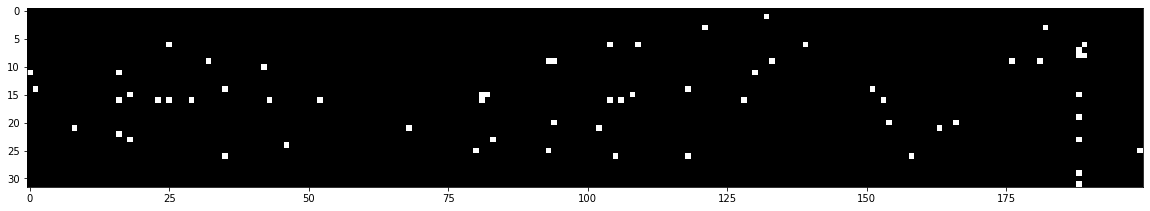

In [29]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

In [31]:
@torch.no_grad() # this decorator disables gradient tracking for the below function
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0357086658477783
val 2.1029491424560547


###  loss log
original:\
train 2.1245384216308594 val 2.168196439743042

fix softmax confidently wrong:\
train 2.07 val 2.13

fix tanh layer too saturated at init:\
train 2.0355966091156006 val 2.1026785373687744

the reason for this is our initializaiton is better,and we spend more time in productive training\
但是这些问题对于deeper and more complex network的影响会更大，这些问题会stack up,network can never train at all if our initialization is bad enough.


###  about dead neurons:
Stochastic Gradient Descent will not only consider a single input xn
, but many of them, and the hope is that not all inputs will put the ReLU on the flat side, so the gradient will be non-zero for some inputs (it may be +ve or -ve though). If at least one input x∗
 has our ReLU on the steep side, then the ReLU is still alive because there's still learning going on and weights getting updated for this neuron. If all inputs put the ReLU on the flat side, there's no hope that the weights change at all and the neuron is dead.

A ReLU may be alive then die due to the gradient step for some input batch driving the weights to smaller values, making zn<0
 for all inputs. A large learning rate amplifies this problem.
 
 (-) Unfortunately, ReLU units can be fragile during training and can “die”. For example, a large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. That is, the ReLU units can irreversibly die during training since they can get knocked off the data manifold. For example, you may find that as much as 40% of your network can be “dead” (i.e. neurons that never activate across the entire training dataset) if the learning rate is set too high. With a proper setting of the learning rate this is less frequently an issue.
 
 Sigmoids saturate and kill gradients. A very undesirable property of the sigmoid neuron is that when the neuron’s activation saturates at either tail of 0 or 1, the gradient at these regions is almost zero. Recall that during backpropagation, this (local) gradient will be multiplied to the gradient of this gate’s output for the whole objective. Therefore, if the local gradient is very small, it will effectively “kill” the gradient and almost no signal will flow through the neuron to its weights and recursively to its data. Additionally, one must pay extra caution when initializing the weights of sigmoid neurons to prevent saturation. For example, if the initial weights are too large then most neurons would become saturated and the network will barely learn.


-----------------------------------------------------

## control the statistics of activations(make it roughly gaussian) ---> relaible trainging and can accept larger learning rate)
### how do we initialize the weights so that the activations stay the rationable values throughout the nn
### 1.kaiming_normal_ : the value before going through activation functions are distruted as 0-1 gaussian,not too saturated, not too small(pointless,tanh is inactive, not working),  at least at initialization (depend on mathematics)
### 2.add BatchNorm layer (usually put after the layer with multiplication, such as linear layer or convolutional layer) (differentiable!)

### kaiming (more of a mathmatic idea) is hard to implement when nn is deep and complex, in this case batchnorm is much eaiser to implement to stablize the nn. 

many activations are contractive functions,relu contract小于0的部分为0，tanh contract 两边的值到-1和1 -> 他们的gain>1.\
check  torch.nn.init.kaiming_normal_()\
它有几个参数：mode是选normalize activations(forwardpass) or normalize gradients(backwardpass) to always be N(0,1),paper showed that this doesn't matter too much, the difference is small. so can just go with the defaulted setting "fan-in"; nonlinearity will change the gain in the formula

tensor(0.0016) tensor(1.0050)
tensor(0.0063) tensor(3.0719)


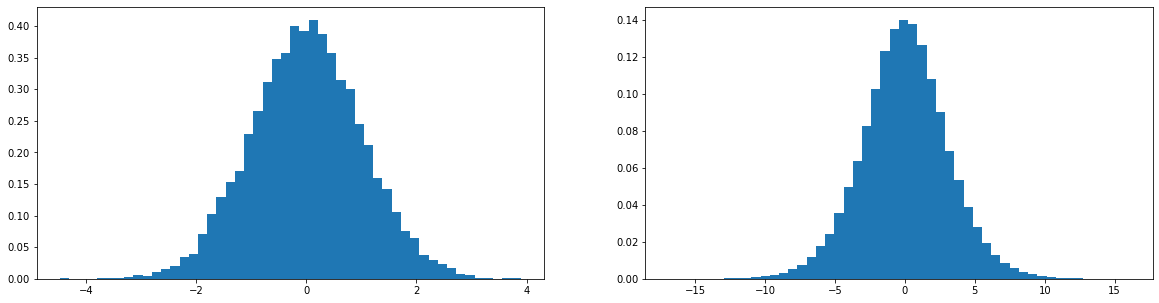

In [32]:
x=torch.randn(1000,10)
w=torch.randn(10,200) #/ 10**0.5      #10=length(input)
#除这个数可以使得x点乘w后y的std不变，依旧等于1 #不除直接两个zero-mean gaussian 相乘的话y会被expand，即std增大，我们想要perserve the std of x
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);

In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #!!kaiming_normal #fan_in
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) #scale and shift
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))  #not within gradient descent optimazation, updated on the side of training

parameters = [C, W1, W2, b2, bngain, bnbias] #!!bngain, bnbias要被训练
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation  #the bias b can be ignored since its effect will be canceled by the subsequent mean subtraction 
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias  #exact gaussian only in the initial stage,backpropagation will change the its scale and location
    #this happens to have regularization effect. output is depend on the batch of inputs, 
    #which is random, this randomness happens to reducde overfitting and have a regularization effect. it works very well in practice
    
    with torch.no_grad(): #for inference(avoid stage two in the below)
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi  #0.001是momentum，if batch size is large，we can choose a relatively large momentum, such as 0.1
      #if batchsize is small, better to choose a small momentum, since the value will vary a lot and laege momentum will not help convergence
    # -------------------------------------------------------------
  # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function  #这个函数包含了softmax

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707


In [9]:
#stage wto
# calibrate the batch norm at the end of training
#用了bnmean_running之后这一步就可以省去了，bnmean and bnmean_running are almost identical
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [11]:
bnmean.shape

torch.Size([1, 200])

In [42]:
bnmean_running

tensor([[-2.4073e+00,  3.7329e-01, -1.2681e+00,  1.2967e+00,  9.6879e-01,
          9.8373e-01,  1.5422e+00, -1.9247e+00,  1.1060e+00,  1.2247e+00,
         -1.8296e+00, -2.7717e+00,  7.1371e-02, -6.1823e-01,  4.3367e-01,
         -6.6872e-01,  7.7062e-01, -2.1880e+00, -2.1887e-01,  1.5707e+00,
         -8.6627e-01,  1.0769e-01, -2.3911e-01,  4.1436e-01,  1.0355e+00,
          1.6324e+00,  1.1980e+00,  9.5800e-01,  3.5302e-01,  1.9480e+00,
         -8.0374e-02, -1.2021e+00, -9.8024e-02, -2.6651e-01, -4.7076e-01,
         -1.4911e+00, -2.6119e+00,  4.6960e-02, -3.0725e-04,  6.0432e-01,
         -2.3633e-01, -9.1242e-01, -2.8294e-01, -1.7836e-01,  6.5023e-01,
          9.0387e-01,  1.5864e+00, -3.9491e-01,  1.9726e+00,  1.0563e+00,
          1.7167e+00, -7.9530e-01,  2.0450e+00,  3.5585e-01,  5.4984e-01,
         -1.9198e+00, -3.1748e-02,  7.1274e-01,  9.0174e-01, -7.9930e-01,
         -6.7666e-01,  9.6929e-01,  4.8908e-01,  2.9598e-01,  1.1424e+00,
          1.6291e+00, -1.3298e+00,  2.

In [43]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias  #why? #allow us to forward pass with single example
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056840419769287


loss log
original:
train 2.1245384216308594 val 2.168196439743042

fix softmax confidently wrong:
train 2.07 val 2.13

fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

add batch norm layer
train 2.0668270587921143 val 2.104844808578491

In [1]:
# SUMMARY + PYTORCHIFYING -----------

In [44]:
# Let's train a deeper network
# The codes here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 
        #using kaiming at initialization #to conserve the deviation to 1,but tanh squashes dthe distribution, so in the below it is neccessary to multiply by a gain 5/3 to boost the data
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x): 
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  #!!!
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) #这俩变量不会被返回，they are internal variables
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance  
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#when adding batchnorm, we can drop "/ fan_in**0.5 " and be more resilent to the setting of gain（除了最后一个图前面几个图都不受影响,所以still need to tune the learning rate）
"""
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
"""
#without batchnormalization,in this case we have to carefully set the gain to get good statistics of both forwardpass and backwardpass :(
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #1.0  #乘以1的话tanh会squash data #乘以一个更大的值的话activation很可能就satuated的了

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [96]:
# Let's train a deeper network
# The codes here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5 
        #using kaiming at initialization #to conserve the deviation to 1,but tanh squashes dthe distribution, so in the below it is neccessary to multiply by a gain 5/3 to boost the data
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x): 
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  #!!!
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) #这俩变量不会被返回，they are internal variables
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance  
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#when adding batchnorm, we can drop "/ fan_in**0.5 " and be more resilent to the setting of gain（除了最后一个图前面几个图都不受影响,所以still need to tune the learning rate）

layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #1.0  #乘以1的话tanh会squash data #乘以一个更大的值的话activation很可能就satuated的了

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [97]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    # 对非叶节点(即中间节点张量)张量启用用于保存梯度的属性(.grad).
    #( 默认情况下对于非叶节点张量是禁用该属性grad,计算完梯度之后就被
    #释放回收内存,不会保存中间结果的梯度.)
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 2.62%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.38%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.75%
layer 14 (      Tanh): mean +0.00, std 0.63, saturated: 2.69%


Text(0.5, 1.0, 'activation distribution')

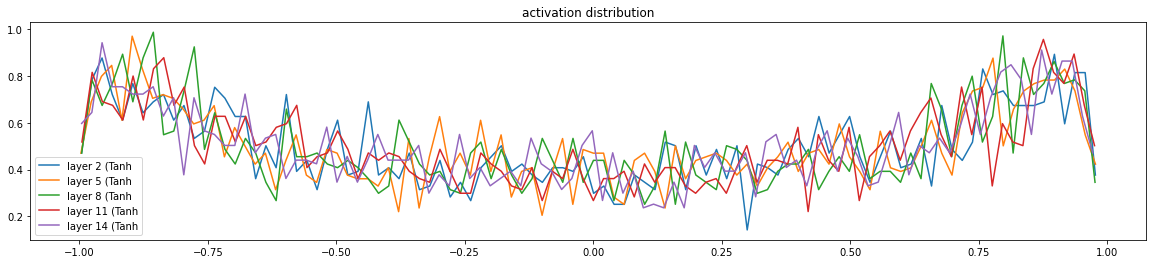

In [98]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
#equil is good, no squnshing no saturating

layer 2 (      Tanh): mean -0.000000, std 3.059682e-03
layer 5 (      Tanh): mean +0.000000, std 2.592222e-03
layer 8 (      Tanh): mean -0.000000, std 2.344924e-03
layer 11 (      Tanh): mean -0.000000, std 2.194399e-03
layer 14 (      Tanh): mean -0.000000, std 1.853027e-03


Text(0.5, 1.0, 'gradient distribution')

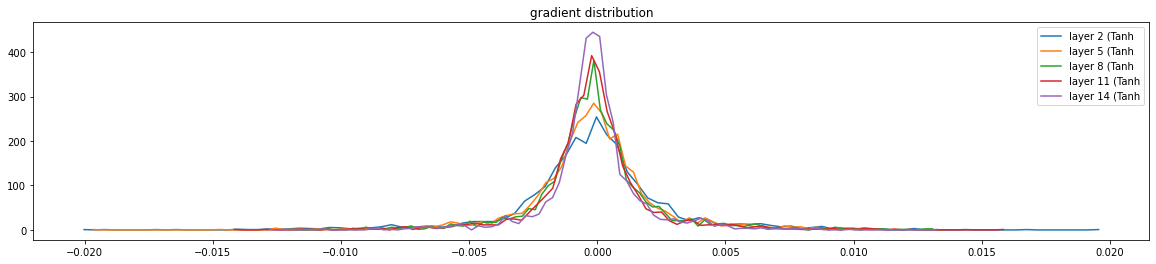

In [99]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
#this table is what we want, the gradients are stable throughout the network

weight   (27, 10) | mean +0.000000 | std 6.574893e-03 | grad:data ratio 6.569362e-03
weight  (30, 100) | mean -0.000003 | std 1.222243e-03 | grad:data ratio 7.155377e-04
weight (100, 100) | mean +0.000008 | std 6.805561e-04 | grad:data ratio 4.096763e-04
weight (100, 100) | mean +0.000002 | std 5.689898e-04 | grad:data ratio 3.389182e-04
weight (100, 100) | mean +0.000003 | std 4.910786e-04 | grad:data ratio 2.937398e-04
weight (100, 100) | mean +0.000001 | std 4.594584e-04 | grad:data ratio 2.745598e-04
weight  (100, 27) | mean +0.000003 | std 6.863169e-04 | grad:data ratio 4.164945e-04


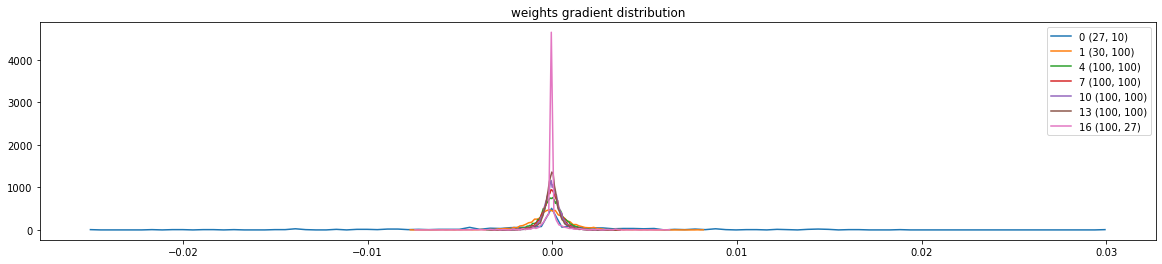

In [100]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: #weights
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [101]:
import numpy as np
np.shape(ud)

(1001, 19)

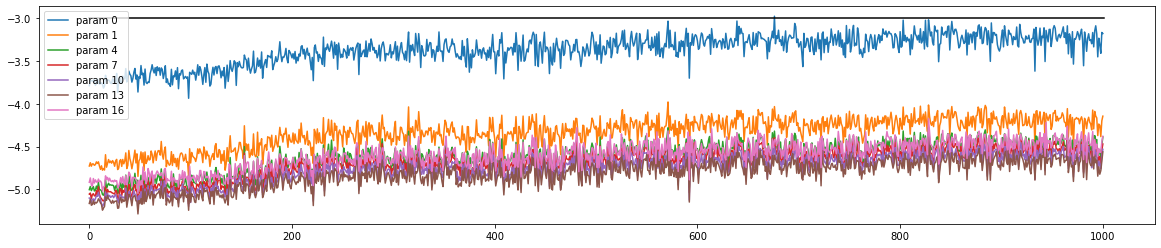

In [102]:
#tune the learning rate
#gain设置的越大这个ratio越小，需要调大lr
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

#the last pink layer of parameters learn faster than other layers, mostly because this seeting "layers[-1].weight *= 0.1" 

In [103]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
      }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.7276175022125244
val 2.725043296813965


In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mrianamyan.
seen.
ndhnyalarethrstendrleg.
adeeed.
eliileli.
jen.
ekein.
ananar.
katzimhltea.
n.
shdbvrgshiries.
kin.
reneliqxnthuoriu.
marede.
jymari.
ehs.
karjansanyan.
hal.
salyansui.
zajelveuren.
